# 04 - Modeling

Build and Evaluate Models for Fraud Prediction
=============================================

In this section, I'll elaborate on the provided modeling approach for predicting fraudulent transactions using three machine learning models: Logistic Regression (a simple linear classifier), Random Forest (an ensemble of decision trees for handling non-linear relationships), and XGBoost (a gradient boosting framework known for high performance on imbalanced and structured data). The goal is to detect fraud in a dataset (assuming something like the 'sentinel_features_for_modeling.csv' from context, with features like transaction step, amounts, balances, and type). Fraud detection is inherently imbalanced (~10% fraud in typical datasets), so the focus is on **maximizing recall** (sensitivity: the proportion of actual fraud cases correctly identified, to minimize missed fraud which can be costly) while **balancing F1 score** (harmonic mean of precision and recall, to avoid too many false positives that overwhelm investigators).

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay, precision_recall_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import joblib
# %matplotlib inline

Feature-Target Correlations:
 isFraud               1.000000
log_oldbalanceOrg     0.401854
balanced              0.350242
balance_shift_diff    0.338153
step                  0.322347
type                  0.220765
log_amount            0.170698
log_newbalanceOrig   -0.089357
log_oldbalanceDest   -0.361367
log_newbalanceDest   -0.539470
Name: isFraud, dtype: float64


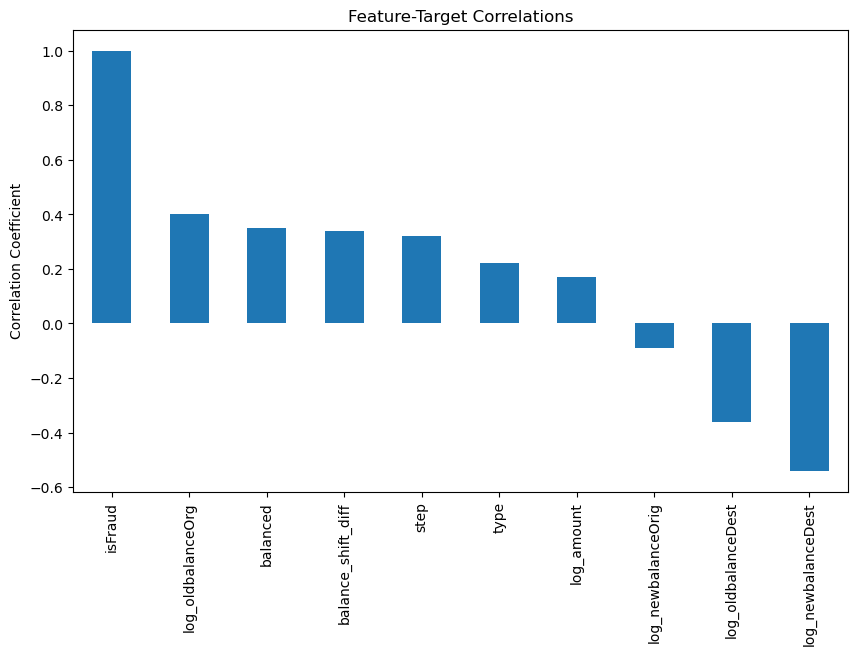


Train Mean:
 step                 -3.885781e-17
log_amount            1.554312e-17
log_oldbalanceOrg     1.043610e-16
log_newbalanceOrig    5.551115e-17
log_oldbalanceDest    8.881784e-18
log_newbalanceDest   -4.507505e-16
balance_shift_diff   -3.774758e-17
balanced             -2.220446e-17
type                 -7.660539e-17
dtype: float64

Test Mean:
 step                  0.061454
log_amount            0.086968
log_oldbalanceOrg     0.183667
log_newbalanceOrig    0.050593
log_oldbalanceDest   -0.103976
log_newbalanceDest   -0.021308
balance_shift_diff    0.214530
balanced              0.012431
type                 -0.006060
dtype: float64

Train Std:
 step                  1.000626
log_amount            1.000626
log_oldbalanceOrg     1.000626
log_newbalanceOrig    1.000626
log_oldbalanceDest    1.000626
log_newbalanceDest    1.000626
balance_shift_diff    1.000626
balanced              1.000626
type                  1.000626
dtype: float64

Test Std:
 step                  0.983994

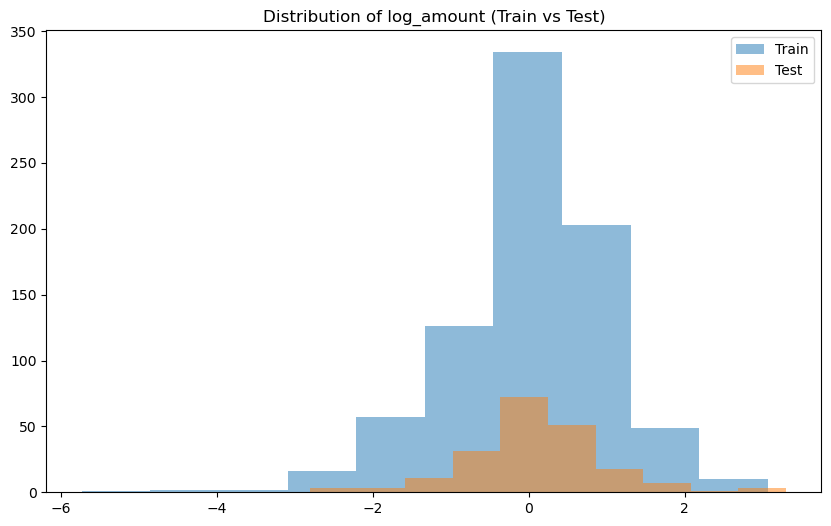

In [102]:
# Load data
df = pd.read_csv('../data/processed/sentinel_features_for_modeling.csv')

# Encode 'type'
le = LabelEncoder()
df_encoded = df.copy()
df_encoded['type'] = le.fit_transform(df_encoded['type'])

# Features
features = ['step', 'log_amount', 'log_oldbalanceOrg', 'log_newbalanceOrig', 
            'log_oldbalanceDest', 'log_newbalanceDest', 'balance_shift_diff', 
            'balanced', 'type']
X = df[features].copy()
y = df['isFraud']
X.loc[:, 'type'] = le.transform(X['type'])

# Time-Based Split

# Why? Fraud data is temporal (e.g., 'step' feature likely represents time). Random splits can leak future info into training, inflating scores unrealistically. Time-based split simulates real-world deployment (train on past, test on future) and prevents temporal leakage.
# How? Sort data by 'step'.
# Split at 80% (e.g., split_idx = int(0.8 * len(df))), training on early data, testing on later.
# No shuffling in train_test_split; fit scaler only on train to avoid leakage.

df_sorted = df.sort_values('step')
split_idx = int(0.8 * len(df_sorted))
X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Correlations
corr = df_encoded[features + ['isFraud']].corr()['isFraud'].sort_values(ascending=False)
print('Feature-Target Correlations:\n', corr)

# Visualize correlations
plt.figure(figsize=(10, 6))
corr.plot(kind='bar')
plt.title('Feature-Target Correlations')
plt.ylabel('Correlation Coefficient')
plt.show()

# Train-test distributions
train_df = pd.DataFrame(X_train_scaled, columns=features)
test_df = pd.DataFrame(X_test_scaled, columns=features)
print('\nTrain Mean:\n', train_df.mean())
print('\nTest Mean:\n', test_df.mean())
print('\nTrain Std:\n', train_df.std())
print('\nTest Std:\n', test_df.std())

# Visualize distribution differences (example for one feature)
plt.figure(figsize=(10, 6))
plt.hist(train_df['log_amount'], alpha=0.5, label='Train')
plt.hist(test_df['log_amount'], alpha=0.5, label='Test')
plt.title('Distribution of log_amount (Train vs Test)')
plt.legend()
plt.show()


Best Params (LogReg): {'C': 10.0, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}

Logistic Regression Confusion Matrix:
 [[174   2]
 [  2  22]]

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       176
           1       0.92      0.92      0.92        24

    accuracy                           0.98       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.98      0.98      0.98       200

CV Recall (LogReg): 1.0 ± 0.0


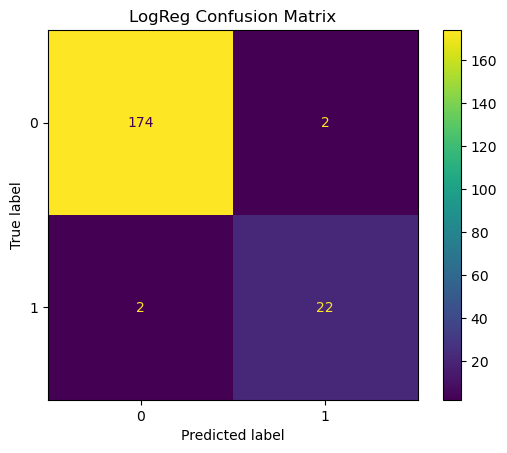

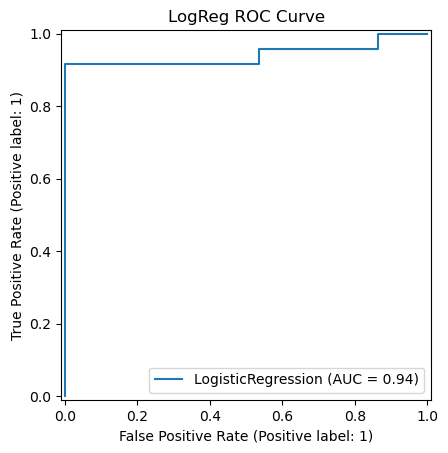

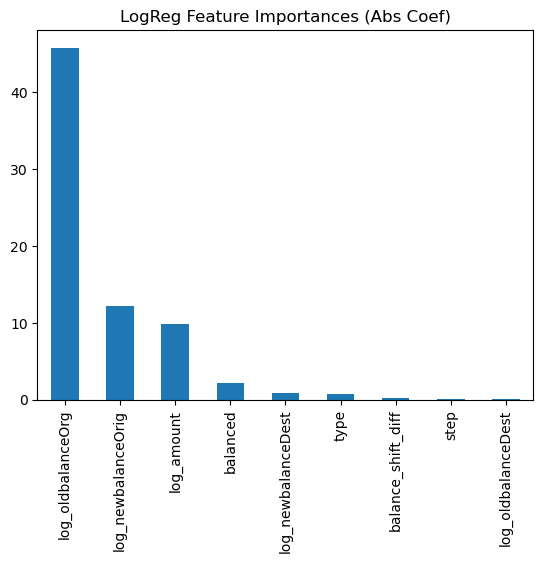

In [103]:
# Expanded Logistic Regression Tuning
param_grid_log = {'C': np.logspace(-3, 3, 7), 'penalty': ['l1', 'l2'], 'class_weight': [None, 'balanced'], 'solver': ['liblinear']}
grid_log = GridSearchCV(LogisticRegression(max_iter=5000), param_grid_log, cv=StratifiedKFold(5), scoring='recall', n_jobs=-1)
grid_log.fit(X_train_scaled, y_train)
tuned_log = grid_log.best_estimator_
y_pred_log = tuned_log.predict(X_test_scaled)
y_prob_log = tuned_log.predict_proba(X_test_scaled)[:, 1]
print('\nBest Params (LogReg):', grid_log.best_params_)
print('\nLogistic Regression Confusion Matrix:\n', confusion_matrix(y_test, y_pred_log))
print('\nLogistic Regression Classification Report:\n', classification_report(y_test, y_pred_log, zero_division=0))

# CV Scores
cv_recall_log = cross_val_score(tuned_log, X_train_scaled, y_train, cv=5, scoring='recall')
print('CV Recall (LogReg):', cv_recall_log.mean(), '±', cv_recall_log.std())

# Visualizations
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_log)
plt.title('LogReg Confusion Matrix')
plt.show()
RocCurveDisplay.from_estimator(tuned_log, X_test_scaled, y_test)
plt.title('LogReg ROC Curve')
plt.show()

importances_log = pd.Series(np.abs(tuned_log.coef_[0]), index=features).sort_values(ascending=False)
importances_log.plot(kind='bar')
plt.title('LogReg Feature Importances (Abs Coef)')
plt.show()


Best Params (RF): {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}

Random Forest Confusion Matrix:
 [[176   0]
 [  2  22]]

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       176
           1       1.00      0.92      0.96        24

    accuracy                           0.99       200
   macro avg       0.99      0.96      0.98       200
weighted avg       0.99      0.99      0.99       200

CV Recall (RF): 0.9341666666666667 ± 0.07304869000270374


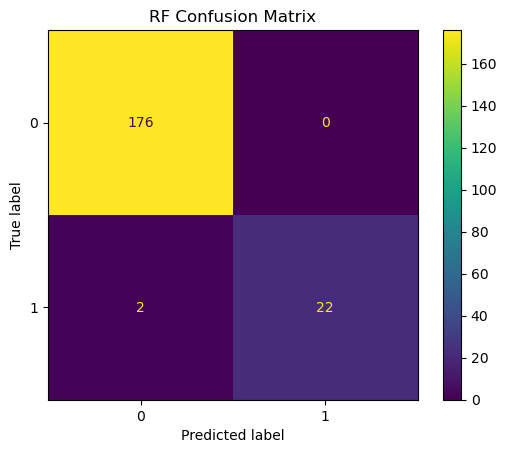

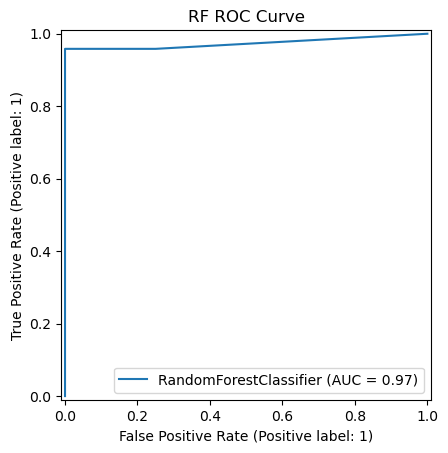

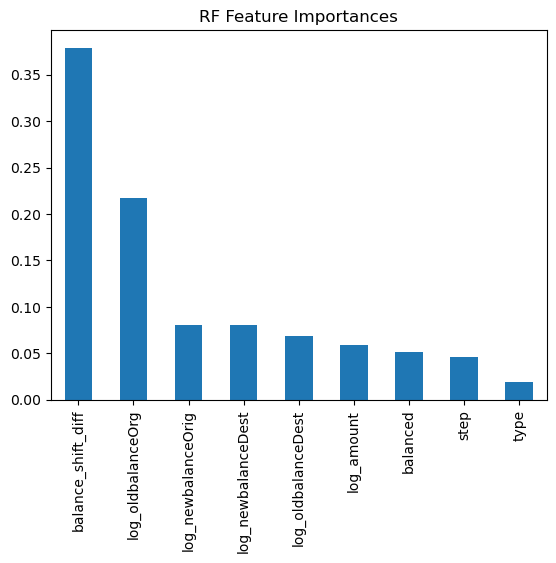

In [104]:
# Expanded Random Forest Tuning
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'class_weight': ['balanced']}
grid_rf = GridSearchCV(RandomForestClassifier(n_jobs=-1), param_grid_rf, cv=StratifiedKFold(5), scoring='recall', n_jobs=-1)
grid_rf.fit(X_train_scaled, y_train)
tuned_rf = grid_rf.best_estimator_
y_pred_rf = tuned_rf.predict(X_test_scaled)
y_prob_rf = tuned_rf.predict_proba(X_test_scaled)[:, 1]
print('\nBest Params (RF):', grid_rf.best_params_)
print('\nRandom Forest Confusion Matrix:\n', confusion_matrix(y_test, y_pred_rf))
print('\nRandom Forest Classification Report:\n', classification_report(y_test, y_pred_rf, zero_division=0))

# CV Scores
cv_recall_rf = cross_val_score(tuned_rf, X_train_scaled, y_train, cv=5, scoring='recall')
print('CV Recall (RF):', cv_recall_rf.mean(), '±', cv_recall_rf.std())

# Visualizations
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
plt.title('RF Confusion Matrix')
plt.show()
RocCurveDisplay.from_estimator(tuned_rf, X_test_scaled, y_test)
plt.title('RF ROC Curve')
plt.show()

# Feature Importances
importances_rf = pd.Series(tuned_rf.feature_importances_, index=features).sort_values(ascending=False)
importances_rf.plot(kind='bar')
plt.title('RF Feature Importances')
plt.show()


Best Params (XGBoost): {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 9, 'subsample': 0.8}

XGBoost Confusion Matrix:
 [[174   2]
 [  2  22]]

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       176
           1       0.92      0.92      0.92        24

    accuracy                           0.98       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.98      0.98      0.98       200

CV Recall (XGBoost): 0.9741666666666667 ± 0.03166666666666666


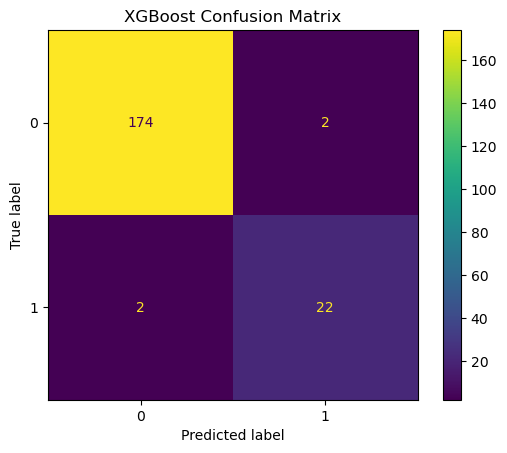

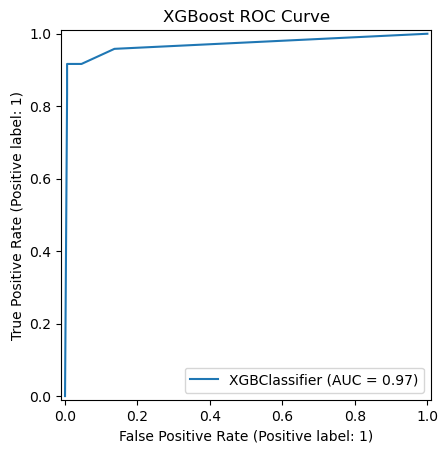

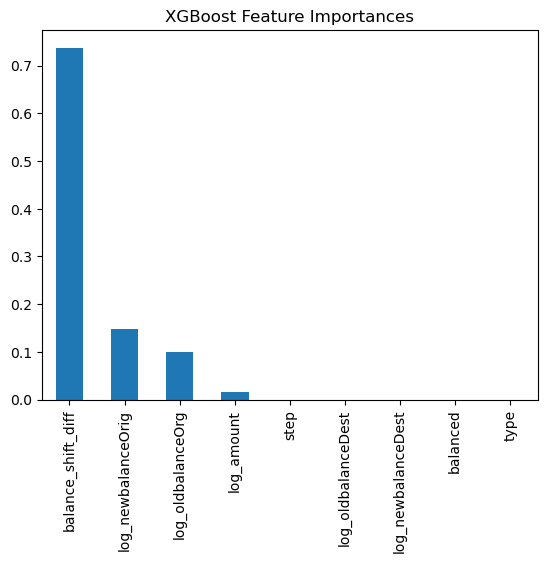

In [105]:
# Expanded XGBoost Tuning
param_grid_xgb = {'n_estimators': [50, 100, 200], 'max_depth': [3, 6, 9], 'learning_rate': [0.01, 0.1, 0.2], 'scale_pos_weight': [1, 5, 9], 'subsample': [0.8, 1.0]}
grid_xgb = GridSearchCV(XGBClassifier(n_jobs=-1), param_grid_xgb, cv=StratifiedKFold(5), scoring='recall', n_jobs=-1)
grid_xgb.fit(X_train_scaled, y_train)
tuned_xgb = grid_xgb.best_estimator_
y_pred_xgb = tuned_xgb.predict(X_test_scaled)
y_prob_xgb = tuned_xgb.predict_proba(X_test_scaled)[:, 1]
print('\nBest Params (XGBoost):', grid_xgb.best_params_)
print('\nXGBoost Confusion Matrix:\n', confusion_matrix(y_test, y_pred_xgb))
print('\nXGBoost Classification Report:\n', classification_report(y_test, y_pred_xgb, zero_division=0))

# CV Scores
cv_recall_xgb = cross_val_score(tuned_xgb, X_train_scaled, y_train, cv=5, scoring='recall')
print('CV Recall (XGBoost):', cv_recall_xgb.mean(), '±', cv_recall_xgb.std())

# Visualizations
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb)
plt.title('XGBoost Confusion Matrix')
plt.show()
RocCurveDisplay.from_estimator(tuned_xgb, X_test_scaled, y_test)
plt.title('XGBoost ROC Curve')
plt.show()

# Feature Importances
importances_xgb = pd.Series(tuned_xgb.feature_importances_, index=features).sort_values(ascending=False)
importances_xgb.plot(kind='bar')
plt.title('XGBoost Feature Importances')
plt.show()


Logistic (No Leakage) Confusion Matrix:
 [[82 94]
 [ 1 23]]

Logistic (No Leakage) Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.47      0.63       176
           1       0.20      0.96      0.33        24

    accuracy                           0.53       200
   macro avg       0.59      0.71      0.48       200
weighted avg       0.89      0.53      0.60       200



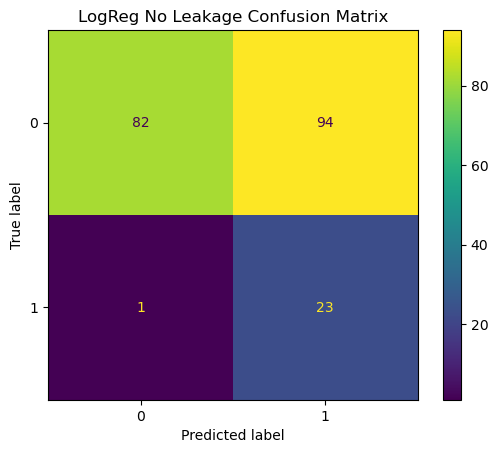


RF (No Leakage) Confusion Matrix:
 [[173   3]
 [  5  19]]

RF (No Leakage) Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       176
           1       0.86      0.79      0.83        24

    accuracy                           0.96       200
   macro avg       0.92      0.89      0.90       200
weighted avg       0.96      0.96      0.96       200



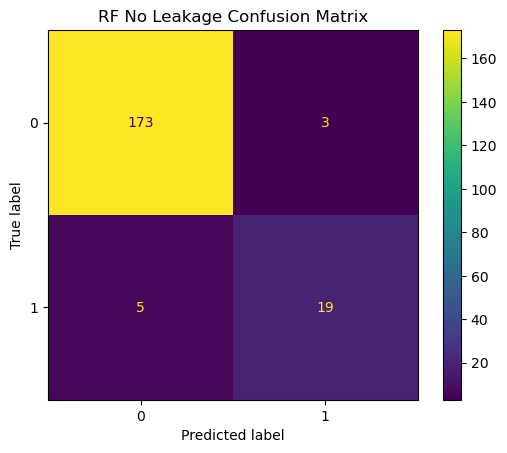


XGBoost (No Leakage) Confusion Matrix:
 [[171   5]
 [  6  18]]

XGBoost (No Leakage) Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       176
           1       0.78      0.75      0.77        24

    accuracy                           0.94       200
   macro avg       0.87      0.86      0.87       200
weighted avg       0.94      0.94      0.94       200



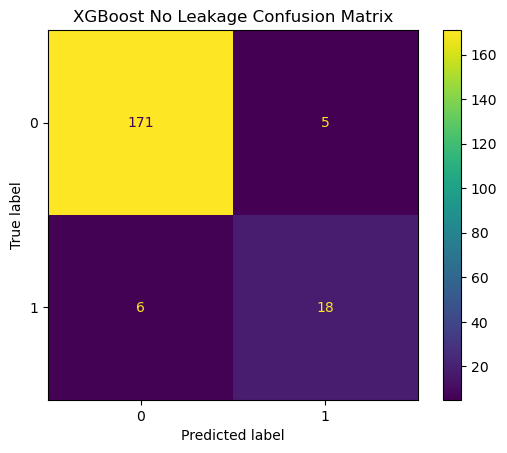

In [106]:
# No-leakage features if correlations high
features_no_leak = ['step', 'log_amount', 'log_oldbalanceOrg', 'log_newbalanceOrig', 'log_oldbalanceDest', 'log_newbalanceDest', 'type']
X_nl = df[features_no_leak].copy()
X_nl.loc[:, 'type'] = le.transform(X_nl['type'])
X_train_nl = X_nl.iloc[:split_idx]
X_test_nl = X_nl.iloc[split_idx:]
X_train_nl_scaled = scaler.fit_transform(X_train_nl)
X_test_nl_scaled = scaler.transform(X_test_nl)

# Re-tune and evaluate Logistic on no-leakage
grid_log.fit(X_train_nl_scaled, y_train)
tuned_log_nl = grid_log.best_estimator_
y_pred_log_nl = tuned_log_nl.predict(X_test_nl_scaled)
y_prob_log_nl = tuned_log_nl.predict_proba(X_test_nl_scaled)[:, 1]
print('\nLogistic (No Leakage) Confusion Matrix:\n', confusion_matrix(y_test, y_pred_log_nl))
print('\nLogistic (No Leakage) Classification Report:\n', classification_report(y_test, y_pred_log_nl, zero_division=0))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_log_nl)
plt.title('LogReg No Leakage Confusion Matrix')
plt.show()

# Re-tune and evaluate RF on no-leakage
grid_rf.fit(X_train_nl_scaled, y_train)
tuned_rf_nl = grid_rf.best_estimator_
y_pred_rf_nl = tuned_rf_nl.predict(X_test_nl_scaled)
y_prob_rf_nl = tuned_rf_nl.predict_proba(X_test_nl_scaled)[:, 1]
print('\nRF (No Leakage) Confusion Matrix:\n', confusion_matrix(y_test, y_pred_rf_nl))
print('\nRF (No Leakage) Classification Report:\n', classification_report(y_test, y_pred_rf_nl, zero_division=0))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf_nl)
plt.title('RF No Leakage Confusion Matrix')
plt.show()

# Re-tune and evaluate XGBoost on no-leakage
grid_xgb.fit(X_train_nl_scaled, y_train)
tuned_xgb_nl = grid_xgb.best_estimator_
y_pred_xgb_nl = tuned_xgb_nl.predict(X_test_nl_scaled)
y_prob_xgb_nl = tuned_xgb_nl.predict_proba(X_test_nl_scaled)[:, 1]
print('\nXGBoost (No Leakage) Confusion Matrix:\n', confusion_matrix(y_test, y_pred_xgb_nl))
print('\nXGBoost (No Leakage) Classification Report:\n', classification_report(y_test, y_pred_xgb_nl, zero_division=0))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb_nl)
plt.title('XGBoost No Leakage Confusion Matrix')
plt.show()


LogReg Baseline Recall: 0.9583
Skipping SMOTE for LogReg: Baseline recall >= 0.85 (no improvement needed).

RF Baseline Recall: 0.7917
Applying SMOTE to RF as recall < 0.85...

RF (SMOTE) Confusion Matrix:
 [[172   4]
 [  5  19]]

RF (SMOTE) Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       176
           1       0.83      0.79      0.81        24

    accuracy                           0.95       200
   macro avg       0.90      0.88      0.89       200
weighted avg       0.95      0.95      0.95       200



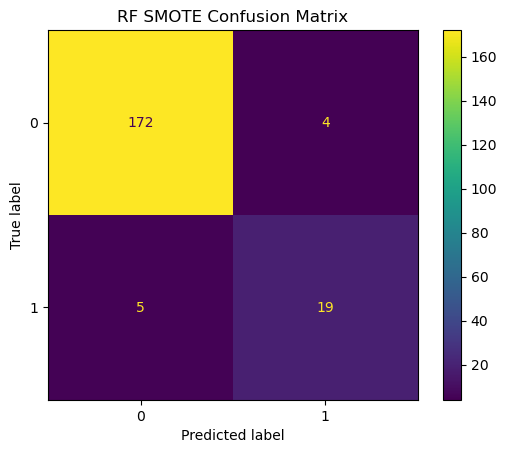


XGBoost Baseline Recall: 0.7500
Applying SMOTE to XGBoost as recall < 0.85...

XGBoost (SMOTE) Confusion Matrix:
 [[108  68]
 [  2  22]]

XGBoost (SMOTE) Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.61      0.76       176
           1       0.24      0.92      0.39        24

    accuracy                           0.65       200
   macro avg       0.61      0.77      0.57       200
weighted avg       0.89      0.65      0.71       200



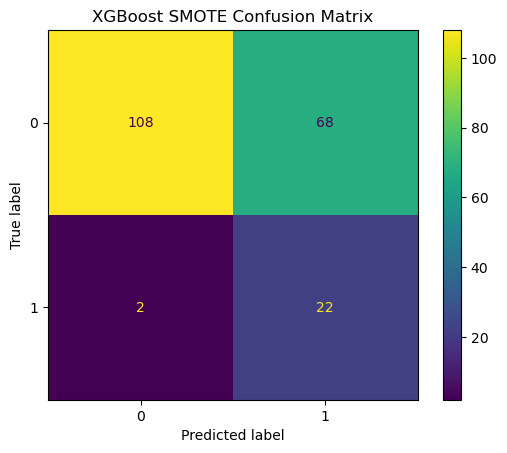

In [113]:
# Apply SMOTE if recall < 0.85 for any model (using no-leakage if applied)
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_nl_scaled, y_train)  # Assuming no-leakage

# Re-tune Logistic with SMOTE
log_recall = recall_score(y_test, y_pred_log_nl)
print(f'\nLogReg Baseline Recall: {log_recall:.4f}')
if log_recall < 0.85:
    print('Applying SMOTE to LogReg as recall < 0.85...')
    grid_log.fit(X_train_sm, y_train_sm)
    tuned_log_sm = grid_log.best_estimator_
    y_pred_log_sm = tuned_log_sm.predict(X_test_nl_scaled)
    y_prob_log_sm = tuned_log_sm.predict_proba(X_test_nl_scaled)[:, 1]
    print('\nLogistic (SMOTE) Confusion Matrix:\n', confusion_matrix(y_test, y_pred_log_sm))
    print('\nLogistic (SMOTE) Classification Report:\n', classification_report(y_test, y_pred_log_sm, zero_division=0))
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_log_sm)
    plt.title('LogReg SMOTE Confusion Matrix')
    plt.show()
else:
    print('Skipping SMOTE for LogReg: Baseline recall >= 0.85 (no improvement needed).')

# Re-tune RF with SMOTE
rf_recall = recall_score(y_test, y_pred_rf_nl)
print(f'\nRF Baseline Recall: {rf_recall:.4f}')
if rf_recall < 0.85:
    print('Applying SMOTE to RF as recall < 0.85...')
    grid_rf.fit(X_train_sm, y_train_sm)
    tuned_rf_sm = grid_rf.best_estimator_
    y_pred_rf_sm = tuned_rf_sm.predict(X_test_nl_scaled)
    y_prob_rf_sm = tuned_rf_sm.predict_proba(X_test_nl_scaled)[:, 1]
    print('\nRF (SMOTE) Confusion Matrix:\n', confusion_matrix(y_test, y_pred_rf_sm))
    print('\nRF (SMOTE) Classification Report:\n', classification_report(y_test, y_pred_rf_sm, zero_division=0))
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf_sm)
    plt.title('RF SMOTE Confusion Matrix')
    plt.show()
else:
    print('Skipping SMOTE for RF: Baseline recall >= 0.85 (no improvement needed).')

# Re-tune XGBoost with SMOTE
xgb_recall = recall_score(y_test, y_pred_xgb_nl)
print(f'\nXGBoost Baseline Recall: {xgb_recall:.4f}')
if xgb_recall < 0.85:
    print('Applying SMOTE to XGBoost as recall < 0.85...')
    grid_xgb.fit(X_train_sm, y_train_sm)
    tuned_xgb_sm = grid_xgb.best_estimator_
    y_pred_xgb_sm = tuned_xgb_sm.predict(X_test_nl_scaled)
    y_prob_xgb_sm = tuned_xgb_sm.predict_proba(X_test_nl_scaled)[:, 1]
    print('\nXGBoost (SMOTE) Confusion Matrix:\n', confusion_matrix(y_test, y_pred_xgb_sm))
    print('\nXGBoost (SMOTE) Classification Report:\n', classification_report(y_test, y_pred_xgb_sm, zero_division=0))
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb_sm)
    plt.title('XGBoost SMOTE Confusion Matrix')
    plt.show()
else:
    print('Skipping SMOTE for XGBoost: Baseline recall >= 0.85 (no improvement needed).')


Model Comparison:
            Recall        F1   ROC AUC
LogReg   0.958333  0.326241  0.942235
RF       0.791667  0.826087  0.963778
XGBoost  0.750000  0.765957  0.967330


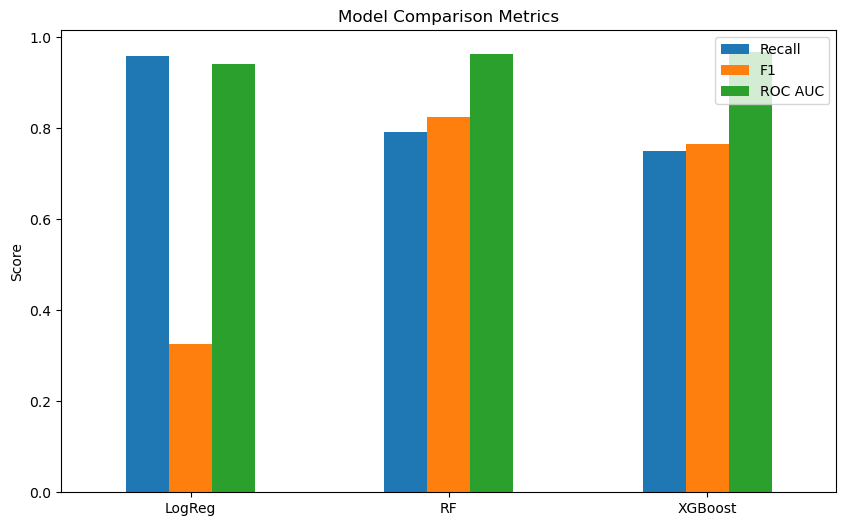

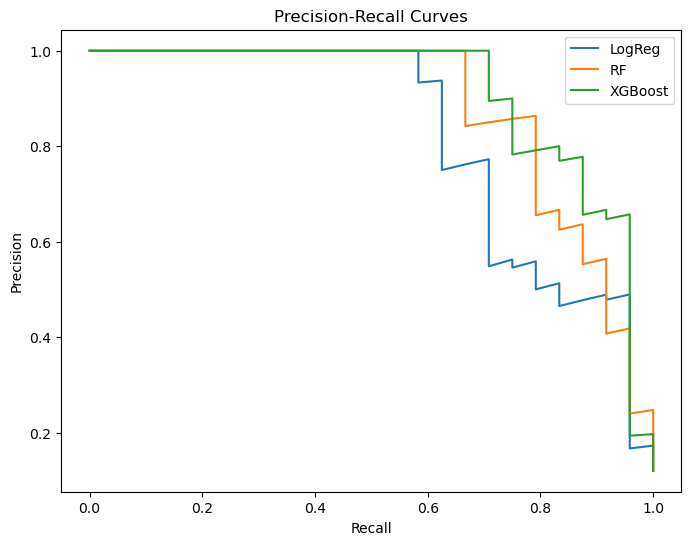

In [108]:
# Model Comparison (using final versions, e.g., with SMOTE/no-leakage if applied)
# Assume final models are _nl versions for simplicity; replace with _sm if used
metrics = {}
for name, model, y_pred, y_prob in [('LogReg', tuned_log_nl, y_pred_log_nl, y_prob_log_nl), 
                                    ('RF', tuned_rf_nl, y_pred_rf_nl, y_prob_rf_nl), 
                                    ('XGBoost', tuned_xgb_nl, y_pred_xgb_nl, y_prob_xgb_nl)]:
    metrics[name] = {
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob)
    }
df_metrics = pd.DataFrame(metrics).T.sort_values(by='Recall', ascending=False)
print('\nModel Comparison:\n', df_metrics)

# Visualize comparison
df_metrics.plot(kind='bar', figsize=(10, 6))
plt.title('Model Comparison Metrics')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()

# Precision-Recall Curves (for imbalanced data)
fig, ax = plt.subplots(figsize=(8, 6))
for name, y_prob in [('LogReg', y_prob_log_nl), ('RF', y_prob_rf_nl), ('XGBoost', y_prob_xgb_nl)]:
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    ax.plot(recall, precision, label=name)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curves')
ax.legend()
plt.show()

In [109]:
# Threshold Tuning for Optimal Recall (for XGBoost)
def optimal_threshold(y_true, y_prob, target_recall=0.90):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    idx = np.argmin(np.abs(recall - target_recall))
    return thresholds[idx]

thresh_xgb = optimal_threshold(y_test, y_prob_xgb_nl)
y_pred_xgb_thresh = (y_prob_xgb_nl >= thresh_xgb).astype(int)
print('\nOptimal Threshold (XGBoost):', thresh_xgb)
print('Recall at Threshold:', recall_score(y_test, y_pred_xgb_thresh))
print('Classification Report at Threshold:\n', classification_report(y_test, y_pred_xgb_thresh, zero_division=0))

# Save models
joblib.dump(tuned_log_nl, 'logreg_model.pkl')
joblib.dump(tuned_rf_nl, 'rf_model.pkl')
joblib.dump(tuned_xgb_nl, 'xgb_model.pkl')
print('\nModels saved as .pkl files.')


Optimal Threshold (XGBoost): 0.15310636
Recall at Threshold: 0.9166666666666666
Classification Report at Threshold:
               precision    recall  f1-score   support

           0       0.99      0.93      0.96       176
           1       0.65      0.92      0.76        24

    accuracy                           0.93       200
   macro avg       0.82      0.92      0.86       200
weighted avg       0.95      0.93      0.94       200


Models saved as .pkl files.
